# **Importing Libraries**

In [42]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# **Loading and Parsing Json Data**

In [43]:
json_path = '/content/user-wallet-transactions.json'

with open(json_path) as f:
    raw_data = json.load(f)

parsed_data = []
for item in raw_data:
    ts = item.get("timestamp")
    action_data = item.get("actionData", {})
    try:
        amount = float(action_data.get("amount", 0)) / 1e6
        asset_price = float(action_data.get("assetPriceUSD", 0))
    except:
        amount = 0.0
        asset_price = 0.0

    parsed_data.append({
        "user": item.get("userWallet"),
        "action": item.get("action"),
        "timestamp": datetime.utcfromtimestamp(ts),
        "amount": amount,
        "asset": action_data.get("assetSymbol"),
        "usd_value": amount * asset_price
    })

df = pd.DataFrame(parsed_data)
df.head()


,user,action,timestamp,amount,asset,usd_value
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,2.000000e+03,USDC,1.987664e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,1.450000e+14,WMATIC,2.856945e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,1.000000e+09,WMATIC,9.223773e+08
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4.000000e+09,WMATIC,4.229933e+09
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,5.015480e-01,USDC,5.026161e-01


In [44]:
print(df['action'].value_counts())

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64


# **Feature Engineering**

In [45]:
def generate_features(df):
    grouped = df.groupby("user")
    records = []

    for user, group in grouped:
        deposit = group[group['action'] == 'deposit']
        borrow = group[group['action'] == 'borrow']
        repay = group[group['action'] == 'repay']
        redeem = group[group['action'] == 'redeemunderlying']
        liquidation = group[group['action'] == 'liquidationcall']

        total_deposit = deposit['usd_value'].sum()
        total_borrow = borrow['usd_value'].sum()
        total_repay = repay['usd_value'].sum()
        total_redeem = redeem['usd_value'].sum()

        features = {
            "user": user,
            "num_transactions": len(group),
            "num_deposit": len(deposit),
            "num_borrow": len(borrow),
            "num_repay": len(repay),
            "num_redeem": len(redeem),
            "num_liquidation": len(liquidation),
            "total_deposit_usd": total_deposit,
            "total_borrow_usd": total_borrow,
            "total_repay_usd": total_repay,
            "total_redeem_usd": total_redeem,
            "borrow_to_deposit_ratio": total_borrow / (total_deposit + 1e-5),
            "repay_to_borrow_ratio": total_repay / (total_borrow + 1e-5),
            "redeem_to_deposit_ratio": total_redeem / (total_deposit + 1e-5),
            "liquidation_rate": len(liquidation) / (len(borrow) + 1e-5),
        }

        records.append(features)

    return pd.DataFrame(records)

features_df = generate_features(df)
features_df.head()


,user,num_transactions,num_deposit,num_borrow,num_repay,num_redeem,num_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,total_redeem_usd,borrow_to_deposit_ratio,repay_to_borrow_ratio,redeem_to_deposit_ratio,liquidation_rate
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,1.987664e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,2.856945e+14,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.152311e+09,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.000000e+00,0.000000,9.803600e+14,0.000000,0.000000e+00,9.803600e+19,0.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,2.065773e+17,6.029762e+16,70150.263791,1.128745e+17,0.291889,1.163400e-12,5.464032e-01,0.0


# **Creating Rule-Based Scores**

In [46]:
def rule_based_score(row):
    score = 500  # Start with a Neutral Base

    # Inactivity
    if row['num_transactions'] < 3:
        score -= 75

    # Liquidation behavior
    if row['num_liquidation'] > 3:
        score -= 250
    elif row['liquidation_rate'] > 0.5:
        score -= 150
    elif row['liquidation_rate'] > 0.2:
        score -= 100
    elif row['liquidation_rate'] > 0:
        score -= 50
    else:
        score += 50  # reward for no liquidation

    # No repayment after borrowing
    if row['num_borrow'] > 0 and row['num_repay'] == 0:
        score -= 100

    # Borrow-to-deposit ratio
    if row['borrow_to_deposit_ratio'] > 2:
        score -= 100
    elif row['borrow_to_deposit_ratio'] > 1.5:
        score -= 75
    elif row['borrow_to_deposit_ratio'] > 1:
        score -= 25
    elif row['borrow_to_deposit_ratio'] > 0.5:
        score += 25
    else:
        score += 100

    # Repayment behavior
    if row['repay_to_borrow_ratio'] >= 1.2:
        score += 200
    elif row['repay_to_borrow_ratio'] >= 1.0:
        score += 150
    elif row['repay_to_borrow_ratio'] >= 0.75:
        score += 75
    elif row['repay_to_borrow_ratio'] < 0.5:
        score -= 100

    # Redemption behavior
    if row['redeem_to_deposit_ratio'] >= 0.95:
        score += 75
    elif row['redeem_to_deposit_ratio'] >= 0.75:
        score += 30
    elif row['redeem_to_deposit_ratio'] < 0.1 and row['num_deposit'] > 0:
        score -= 25

    # Healthy usage behavior
    if row['num_deposit'] >= 5 and row['num_repay'] >= 3 and row['num_liquidation'] == 0:
        score += 100

    # Clipping between 0 to 1000
    return int(max(0, min(score, 1000)))



# Step 2: Apply rule-based scoring
features_df['rule_score'] = features_df.apply(rule_based_score, axis=1)
print(features_df.head())


                                         user  num_transactions  num_deposit  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                 1            1   
1  0x000000000051d07a4fb3bd10121a343d85818da6                 1            1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc                 2            2   
3  0x0000000000e189dd664b9ab08a33c4839953852c                17            0   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee               399          250   

   num_borrow  num_repay  num_redeem  num_liquidation  total_deposit_usd  \
0           0          0           0                0       1.987664e+03   
1           0          0           0                0       2.856945e+14   
2           0          0           0                0       5.152311e+09   
3           0          0          17                0       0.000000e+00   
4          15          4         130                0       2.065773e+17   

   total_borrow_usd  total_repay_usd  total_redeem_usd  \
0   

# **Graph for Wallet Credit Score Distribution**

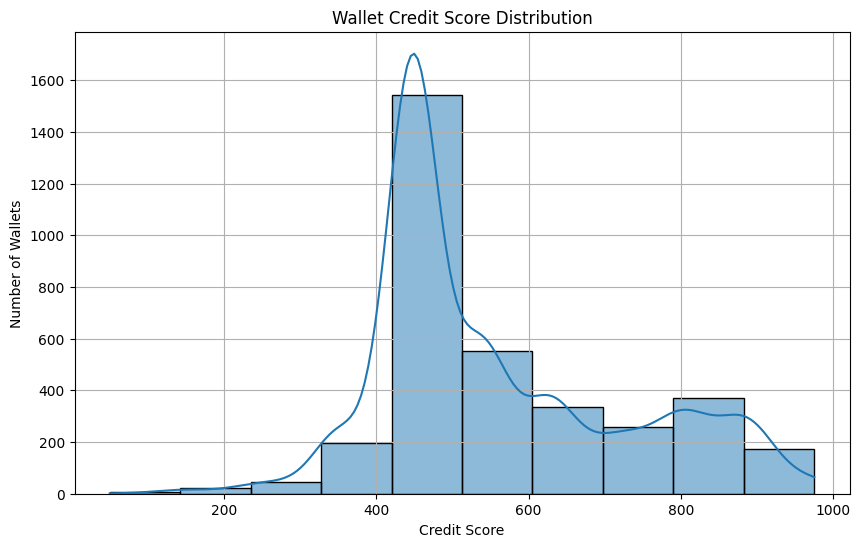

In [47]:
plt.figure(figsize=(10,6))
sns.histplot(features_df['rule_score'], bins=10, kde=True)
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.savefig('score_distribution.png')
plt.show()
